### data setup

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import differential_evolution as de

In [161]:
raw_data = pd.read_csv('dados\MC carpel H 5-min.csv')
raw_data.dtga = -1 * raw_data.dtga
raw_data.head(5)

,time,temperature,tga,dtga,dtga_5
0,0,450.35,10.32687,0.000092,-0.00046
1,5,450.85,10.32643,0.000088,-0.00044
2,10,451.25,10.32595,0.000096,-0.00048
3,15,451.65,10.32550,0.000090,-0.00045
4,20,452.15,10.32502,0.000096,-0.00048


In [162]:
raw_data.dtypes

time             int64
temperature    float64
tga            float64
dtga           float64
dtga_5         float64
dtype: object

### functions

In [163]:
def time_interval_decorator(function):
    import time
    def wrapper(*args):
        initial_time = time.time()
        function(*args)
        final_time = time.time()
        elapsed_time = final_time - initial_time
        print(f'Time elapsed: {elapsed_time} seconds.')
    return wrapper

def theorical_temperature(data):
    initial_temperature = data.temperature.iloc[0]
    heating_rate = 5 # K/min
    return initial_temperature + heating_rate/60 * data.time

def conversion(data):
    initial_mass = data.tga.iloc[0]
    final_mass = data.tga.iloc[-1]
    
    return (initial_mass - data.tga) / (initial_mass - final_mass)

def conversion_rate(order, data):
    return (1 - data.conversion)**order

def arrhenius(X, data):
    gas_constant = 8.314 # J/mol*K
    
    pre_exp_factor = X[0]
    activation_energy = X[1]
    order = X[2]

    rate = pre_exp_factor * np.exp( -activation_energy / (gas_constant * data.theoretical_temperature)) # continue on the next line 
    rate *= conversion_rate(order, data)
    return rate

def rpi_model_for_mass(X, data):
    # component parameters = [(component_fraction), (pre_exp_factor), (activation_energy), (order)]
    hemicellulosis_params = X[:4]
    cellulosis_params = X[4:8]
    lignin_params = X[8:12]

    model_hemicellulosis = -hemicellulosis_params[0] * arrhenius(hemicellulosis_params[1:], data)
    model_cellulosis = -cellulosis_params[0] * arrhenius(cellulosis_params[1:], data)
    model_lignin = -lignin_params[0] * arrhenius(lignin_params[1:], data)

    complete_model = model_hemicellulosis + model_cellulosis + model_lignin

    data['model_hemicellulosis'] = model_hemicellulosis
    data['model_cellulosis'] = model_cellulosis
    data['model_lignin'] = model_lignin
    data['RPI_model'] = complete_model

    return complete_model

def objective_function(X, data):
    data['err'] = (rpi_model_for_mass(X, data) - data['tga'])**2
    return data.err.sum()

### Prelimiar calculations

In [164]:
# duplicating the data for safeguarding
data = raw_data.drop('dtga_5', axis=1).copy()

# conversion of mass over time
data['conversion'] = conversion(data)

# calculating theoretical temperature
data['theoretical_temperature'] = theorical_temperature(data)

data.head(5)

,time,temperature,tga,dtga,conversion,theoretical_temperature
0,0,450.35,10.32687,0.000092,0.000000,450.350000
1,5,450.85,10.32643,0.000088,0.000066,450.766667
2,10,451.25,10.32595,0.000096,0.000137,451.183333
3,15,451.65,10.32550,0.000090,0.000205,451.600000
4,20,452.15,10.32502,0.000096,0.000276,452.016667


In [165]:
@time_interval_decorator
def main():
    # Bounds follows: [(component_fraction), (pre_exp_factor), (activation_energy), (order)]
    range_lower = 0.8
    range_upper = 1.2

    # initial guess based on previous runs
    hemicellulosis = [0.03391792033750687, 5290573496.8535385, 2084391091.1153343, 0.5065341650118638]
    cellulosis = [0.028834076824494913, 5949340620.9732895, 379402270.3767601, 0.5928635453603937]
    lignin = [0.11119404742492646, 1101327927.2451239, 7569822217.522224, 2.4866757976029077]

    hemicellulosis = [(range_lower * hemicellulosis[0], range_upper * hemicellulosis[0]), 
                      (range_lower * hemicellulosis[1], range_upper * hemicellulosis[1]),
                      (range_lower * hemicellulosis[2], range_upper * hemicellulosis[2]),
                      (range_lower * hemicellulosis[3], range_upper * hemicellulosis[3])
                      ]

    cellulosis = [(range_lower * cellulosis[0], range_upper * cellulosis[0]), 
                  (range_lower * cellulosis[1], range_upper * cellulosis[1]),
                  (range_lower * cellulosis[2], range_upper * cellulosis[2]),
                  (range_lower * cellulosis[3], range_upper * cellulosis[3])
                  ]

    lignin = [(range_lower * lignin[0], range_upper * lignin[0]), 
              (range_lower * lignin[1], range_upper * lignin[1]),
              (range_lower * lignin[2], range_upper * lignin[2]),
              (range_lower * lignin[3], range_upper * lignin[3])
              ]

    bounds = hemicellulosis + cellulosis + lignin

    # DE hyper-parameters
    strategy = 'best1bin'
    maxiter = 1000
    popsize = 15
    tol = 1e-2
    mutation = (0.5, 1)
    recombination = 0.7

    results = de(objective_function, 
                bounds = bounds,
                args = (data, ),
                strategy = strategy,
                maxiter = maxiter,
                popsize = popsize,
                tol = tol,
                mutation = mutation,
                recombination = recombination,
                )
    
    params = results.x
    opt_fun = results.fun
    results_hemicellulosis = params[:4]
    results_cellulosis = params[4:8]
    results_lignin = params[8:12]
    
    print(f"""Results:
------------------------------------------
    hemicellulosis = {list(results_hemicellulosis)}
    cellulosis = {list(results_cellulosis)}
    lignin = {list(results_lignin)}
------------------------------------------
Function value: {opt_fun}
""")

if __name__ == "__main__":
    main()

Results:
------------------------------------------
    hemicellulosis = [0.02816454303419758, 6279870732.881116, 1986632993.746132, 0.5728329877427571]
    cellulosis = [0.034066778976285475, 6946419279.591539, 434360226.5990561, 0.47689659815783814]
    lignin = [0.099145946894702, 1099087535.926598, 6759022397.975094, 2.1751284355946114]
------------------------------------------
Function value: 43155.4110313041

Time elapsed: 1.3991508483886719 seconds.


In [166]:
data.head(5)

,time,temperature,tga,dtga,conversion,theoretical_temperature,model_hemicellulosis,model_cellulosis,model_lignin,RPI_model,err
0,0,450.35,10.32687,0.000092,0.000000,450.350000,-0.0,-0.0,-0.0,-0.0,106.644244
1,5,450.85,10.32643,0.000088,0.000066,450.766667,-0.0,-0.0,-0.0,-0.0,106.635157
2,10,451.25,10.32595,0.000096,0.000137,451.183333,-0.0,-0.0,-0.0,-0.0,106.625243
3,15,451.65,10.32550,0.000090,0.000205,451.600000,-0.0,-0.0,-0.0,-0.0,106.615950
4,20,452.15,10.32502,0.000096,0.000276,452.016667,-0.0,-0.0,-0.0,-0.0,106.606038


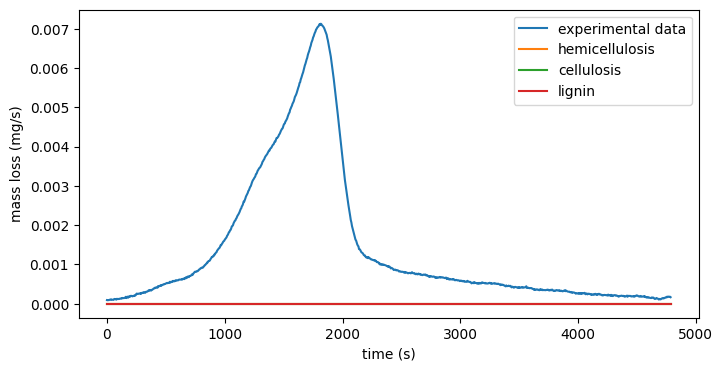

In [167]:
data.plot(x='time',
          y=['dtga','model_hemicellulosis', 'model_cellulosis', 'model_lignin'],
          kind='line',
          figsize=(8,4),
          label=['experimental data', 'hemicellulosis', 'cellulosis', 'lignin'],
          xlabel='time (s)',
          ylabel='mass loss (mg/s)');
